# Amplitude Damping Channel 
This example demonstrates the **Unrestricted adaptive variational quantum dynamics (UAVQD)** simulation for an **amplitude damping channel**, a canonical model for energy dissipation in open quantum systems.

The simulation employs the **vectorized Lindblad formalism** within the `QMAD` framework to propagate the system dynamics, and the results are validated against the **QuTiP master equation solver**.

## Importing Required Libraries

We begin by importing the necessary numerical and plotting libraries, along with modules from the `qmad` that enable the simulation of open quantum system dynamics using adaptive variational methods.

In [1]:
import numpy as np
from qflux.variational_methods.qmad.solver import solve_avq_vect
from qflux.variational_methods.qmad.effh import VectorizedEffectiveHamiltonian
from qflux.variational_methods.qmad.ansatzVect import Ansatz
import matplotlib.pyplot as plt

## Defining the Amplitude Damping Model

The amplitude damping channel describes spontaneous emission from an excited state $|1\rangle$ to a ground state $|0\rangle$ with decay rate $\gamma$.

We define the Pauli operators and construct the **raising operator** $\sigma_+$, which acts as the Lindblad operator for decay. The effective Hamiltonian is vectorized for simulation using the AVQD framework.

In [2]:
sx = np.array([[0, 1], [1, 0]])
sy = np.array([[0, -1j], [1j, 0]])
sp = (sx + 1j * sy) / 2  # raising operator
Id = np.eye(2, dtype=np.complex128)

# Simulation parameters
tf = 1000e-12   # Final time (seconds)
dt = 1000e-13   # Time step (seconds)
gamma = 1.52e9  # Damping rate (Hz)

# Define the Hamiltonian and Lindblad operator
H = np.eye(2, dtype=np.complex128)
lind = sp
H = VectorizedEffectiveHamiltonian(H, gamma, lind)

# Initial state (normalized two-level superposition)
u0 = np.array([1 / 2, np.sqrt(3)/2], dtype=np.complex128)

# Define ansatz and solve
ansatz = Ansatz(u0, relrcut=1e-6)
res = solve_avq_vect(H, ansatz, [0, tf], dt)

## Extracting Populations and Visualizing AVQD Results

We extract the ground and excited state populations from the simulation results and visualize their temporal evolution. The amplitude damping effect manifests as a monotonic decrease in excited state population accompanied by a corresponding rise in the ground state population.

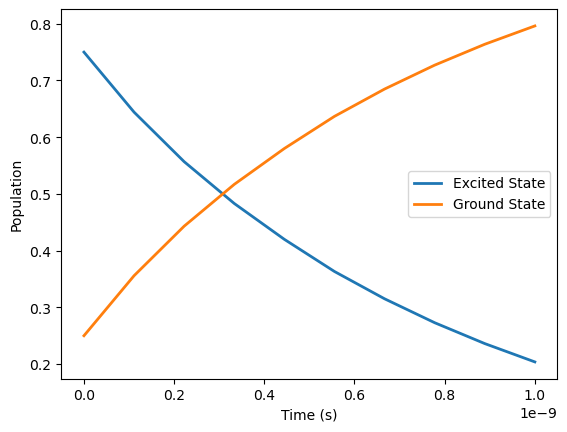

In [3]:
excited = [res.u[i][1, 1].real for i in range(10)]
ground = [res.u[i][0, 0].real for i in range(10)]
times = np.linspace(0, 1000e-12, 10)

plt.plot(times, excited, label="Excited State", linewidth=2)
plt.plot(times, ground, label="Ground State", linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Population")
plt.legend()
plt.show()

## Implementing the Master Equation Benchmark in QuTiP

To verify the variational dynamics, we next solve the same amplitude damping problem using the **QuTiP** master equation solver (`mesolve`). This provides an exact reference solution for open-system dynamics under the Lindblad formalism.

In [4]:
from qutip import mesolve, Qobj

def qutip_prop(H, rho0, time_arr, c_ops, observable):
    """
    Wrapper around QuTiP's mesolve for open system propagation.
    Inputs:
    - H: Hamiltonian (Qobj)
    - rho0: Initial density matrix (Qobj)
    - time_arr: Time grid (array)
    - c_ops: Collapse operators (list of Qobj)
    - observable: Observable(s) for expectation value calculation (Qobj or list)
    Returns: Expectation value(s) over time.
    """
    result = mesolve(H, rho0, time_arr, c_ops, observable)
    return result.expect

### Defining the QuTiP Model Parameters

We now define the same Hamiltonian, damping rate, and initial state within QuTiP's framework. The populations of the ground and excited states are computed from the master equation evolution and compared with the AVQD results.

In [5]:
from qutip import *

# Operators
sx = np.array([[0, 1], [1, 0]])
sy = np.array([[0, -1j], [1j, 0]])
sp = (sx + 1j * sy) / 2
sm = Qobj(sp)

# Identity Hamiltonian
H = Qobj(np.eye(2, dtype=np.complex128))

# Time and parameters
tf = 1000e-12
dt = 1000e-14
times = np.arange(0, tf, dt)
gamma = 1.52e9

# Initial state and collapse operator
u0 = np.array([1 / 2, np.sqrt(3) / 2], dtype=np.complex128)
u0 = u0 / np.linalg.norm(u0)
psi0 = Qobj(u0)
rho0 = psi0 * psi0.dag()
c_ops = [np.sqrt(gamma) * sm]

# Define projectors for populations
proj_excited = basis(2, 1) * basis(2, 1).dag()
proj_ground = basis(2, 0) * basis(2, 0).dag()

# Solve and extract populations
result = qutip_prop(H, rho0, times, c_ops, [proj_ground, proj_excited])
ground_population, excited_population = result[0], result[1]

## Comparing QuTiP and AVQD Results

The figure below compares the **exact QuTiP master equation** results with the **variational AVQD** simulation results. The strong agreement between both methods demonstrates that the variational approach accurately captures the dissipative decay behavior of the amplitude damping channel.

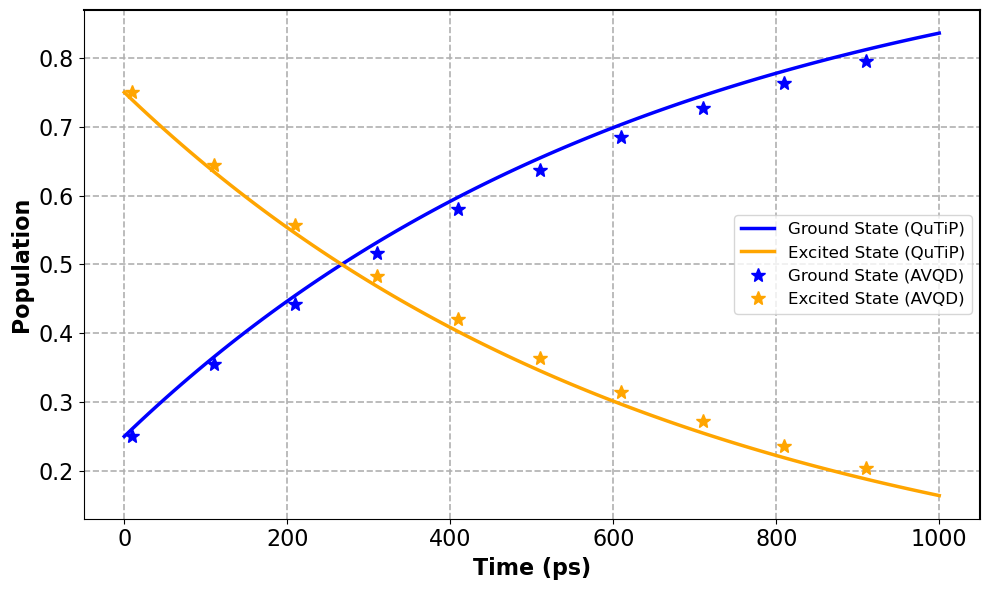

In [6]:
plt.figure(figsize=(10, 6))
line_width, marker_size = 2.5, 10

# Color scheme
ground_color = 'blue'
excited_color = 'orange'

# Plot QuTiP results
plt.plot(times * 1e12, ground_population, label="Ground State (QuTiP)", color=ground_color, linewidth=line_width)
plt.plot(times * 1e12, excited_population, label="Excited State (QuTiP)", color=excited_color, linewidth=line_width)

# Overlay AVQD (UAVQDS) results with markers
plt.plot(times[1::10] * 1e12, ground, '*', label="Ground State (AVQD)", color=ground_color, markersize=marker_size)
plt.plot(times[1::10] * 1e12, excited, '*', label="Excited State (AVQD)", color=excited_color, markersize=marker_size)

# Styling
plt.xlabel('Time (ps)', fontsize=16, fontweight='bold')
plt.ylabel('Population', fontsize=16, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(fontsize=12, loc='best')
plt.grid(True, linestyle='--', linewidth=1.2)
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.tight_layout()
plt.savefig("population_comparison.png", dpi=300)
plt.show()

## References

- *Chen et al.*, **Adaptive Variational Quantum Dynamics for Open Systems**, *npj Quantum Information* (2024).  
- *Saurabh Shivpuje et al.*, **Designing Variational Ansatz for Quantum-Enabled Simulation of Non-Unitary Dynamical Evolution — An Excursion into Dicke Superradiance**, *Advanced Quantum Technologies* (2024).